In [1]:
import os 
from ipsl_dataset import IPSL_DCPP
import lightning.pytorch as pl
import torch
from unet import UNet2
# from ipsl_dataset import input_variables
scratch = os.environ['SCRATCH']
work = os.environ['WORK']
run_name = ''
checkpoint_path = f'{scratch}/{run_name}_epoch=299.ckpt'
checkpoint_path = f'{scratch}/checkpoints/_epoch=01.ckpt'

In [2]:
checkpoint = torch.load(checkpoint_path,map_location=torch.device('cpu'))
test = IPSL_DCPP('test')
test_dataloader = torch.utils.data.DataLoader(test,batch_size=1,shuffle=False,num_workers=1)
model = UNet2(135)
model.load_state_dict(checkpoint['state_dict'])


1it [00:00,  2.93it/s]


<All keys matched successfully>

In [3]:
trainer = pl.Trainer()
predictions = trainer.predict(model, test_dataloader)
# 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
SLURM auto-requeueing enabled. Setting signal handlers.
/gpfsdswork/projects/rech/mlr/udy16au/miniconda3/envs/env_gpu3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [4]:
x = predictions[0]
y = predictions[1]

In [5]:
x[0][0,77,:,:]

tensor([[-0.1624, -0.2835, -0.3222,  ..., -0.3214, -0.3587, -0.2623],
        [-0.0988, -0.1617, -0.2161,  ..., -0.2082, -0.2279, -0.1749],
        [-0.0631, -0.1876, -0.2530,  ..., -0.1968, -0.2220, -0.1956],
        ...,
        [ 0.4032,  0.6215,  0.7981,  ...,  0.6260,  0.6355,  0.4498],
        [ 0.4272,  0.6433,  0.7956,  ...,  0.6556,  0.6246,  0.4100],
        [ 0.3212,  0.5073,  0.6188,  ...,  0.5539,  0.5357,  0.3914]])

In [6]:
import xarray as xr
ds = xr.open_dataset(test.files[0])

In [7]:
shell = ds.isel(time=0)

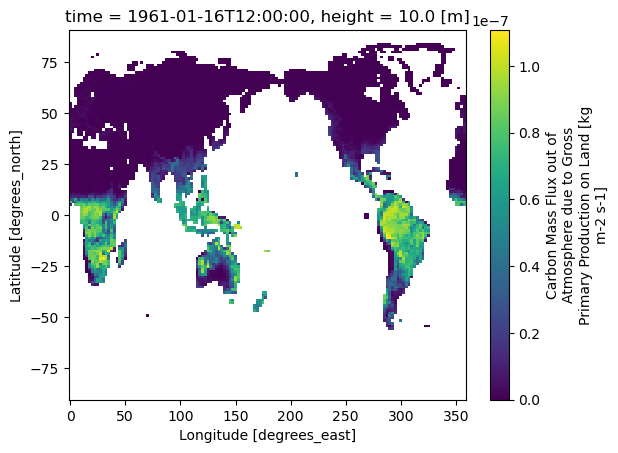

In [8]:
import matplotlib.pyplot as plt
shell['gpp'].plot.pcolormesh()

In [9]:
input_variables.index('gpp')

20

In [10]:
shell['gpp'].data = x[0][0,20,:,:]

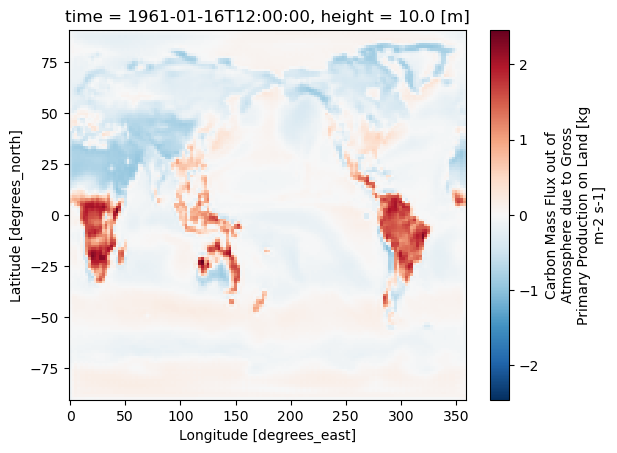

In [11]:
shell['gpp'].plot.pcolormesh()

In [2]:
import os 
os.path.exists('data/input_stds.npy')


True